In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.weightstats import ttest_ind

In [2]:
# Set plot options
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.dpi'] = 100
sns.set_style("darkgrid")

In [3]:
# Set print options
np.set_printoptions(suppress=True, precision=4, edgeitems = 7)
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

In [4]:
# Create random generator
random_seed = 1923
rng = np.random.default_rng(random_seed)

## Data generation

### Fixed parameters

In [5]:
# Avg. visitors per day & its noise, as Poisson distributions
lam_visitors = 100
lam_visitors_noise = 5

In [6]:
# Conversion rates
conversion_control = 0.15
conversion_experiment = 0.20

# Noise in conversion rates, as Beta distribution
# Mean = alpha / (alpha + beta)
conversion_noise_alpha = 2  
conversion_noise_beta = 100

In [7]:
# Test conversion rate noise generation (will be randomly negated)
np.random.beta(conversion_noise_alpha, conversion_noise_beta, 25)

array([0.0212, 0.0199, 0.035 , 0.0247, 0.0109, 0.0082, 0.0298, 0.0085,
       0.0187, 0.0186, 0.0241, 0.0017, 0.0062, 0.0098, 0.0096, 0.0241,
       0.0184, 0.039 , 0.021 , 0.0075, 0.0262, 0.0059, 0.0471, 0.0445,
       0.0058])

### Data generating functions

In [8]:
def get_daily_visitors(days):
    noise = rng.poisson(lam_visitors_noise, days) * np.random.choice([1, -1], days)
    daily_visitors = rng.poisson(lam_visitors, days) + noise
    return daily_visitors

In [9]:
def get_daily_conversions(daily_visitors, conversion_rate):
    n_days = len(daily_visitors)
    noise = np.random.choice([1, -1], n_days) * np.random.beta(conversion_noise_alpha, conversion_noise_beta, n_days)
    daily_conversions = daily_visitors * (conversion_rate + noise)
    return daily_conversions.astype(int)

In [10]:
def get_conversions_array(daily_visitors, daily_conversions):
    n_visitors = sum(daily_visitors)
    n_converted = sum(daily_conversions)
    converted_array = np.ones(n_converted)
    non_converted_array = np.zeros(n_visitors - n_converted)
    return np.concatenate([converted_array, non_converted_array])

In [11]:
def relative_uplift(experiment, control):
    return (experiment / control) - 1

In [12]:
# Test daily visitors generation
n_test_days = 5
get_daily_visitors(n_test_days)

array([ 89,  86,  99, 118,  94], dtype=int64)

In [13]:
# Test daily conversions generation
get_daily_conversions(get_daily_visitors(n_test_days), conversion_control)

array([14, 15, 14, 11, 12])

In [14]:
# Test conversions array generation
get_conversions_array(
    get_daily_visitors(n_test_days),
    get_daily_conversions(get_daily_visitors(n_test_days), conversion_control)

)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [15]:
# Test calculating conversion rate
np.mean(
    get_conversions_array(
    get_daily_visitors(n_test_days),
    get_daily_conversions(get_daily_visitors(n_test_days), conversion_control)
)
)

0.1342155009451796

In [16]:
# Test calculating sample standard deviation
np.std(
    get_conversions_array(
    get_daily_visitors(n_test_days),
    get_daily_conversions(get_daily_visitors(n_test_days), conversion_control)
)
)

0.35582013857743894

## Power analysis

In [17]:
# Minimum practically significant raw effect size
min_raw_effect = conversion_experiment - conversion_control

# Expected sample standard deviation
expected_std = 0.3

# Minimum practically significant standardized effect
min_std_effect = (min_raw_effect / expected_std)

# Considered standardized effect sizes
effect_sizes = [
    min_std_effect * 0.5, 
    min_std_effect * 0.8, 
    min_std_effect, 
    min_std_effect * 1.2,
    min_std_effect * 1.5
    ]

# Considered significance levels
alphas = [0.01, 0.05, 0.10]

# Considered n. of days
n_days = np.arange(1, 22, 1)

# Dictionary of parameters
dict_power = {
    "effect_size": effect_sizes,
    "alpha": alphas,
    "n_days": n_days
}

In [18]:
# Create power calculator
power_calc = TTestIndPower(alternative = "larger")

In [19]:
# Function to get each parameter combination
def grid_configs(dictionary):
    for combination in product(*dictionary.values()):
        yield dict(zip(dictionary.keys(), combination))

In [20]:
# Calculate power for each parameter combination
effects_list = []
alphas_list = []
days_list = []
power_list = []
for config in grid_configs(dict_power):

    # Calculate power
    n_obs = np.sum(get_daily_visitors(config["n_days"]))

    power = power_calc.power(
        effect_size = config["effect_size"],
        nobs1 = n_obs,
        alpha = config["alpha"],
        ratio = 1
    )

    # Append parameters to list
    effects_list.append(config["effect_size"])
    alphas_list.append(config["alpha"])
    days_list.append(config["n_days"])
    power_list.append(power)

In [21]:
# Create dataframe of power calculations
power_data = pd.DataFrame({
    "effect_size": [round(x, 2) for x in effects_list],
    "alpha": [round(x, 2) for x in alphas_list],
    "days": days_list,
    "power": [round(x, 2) for x in power_list]
})

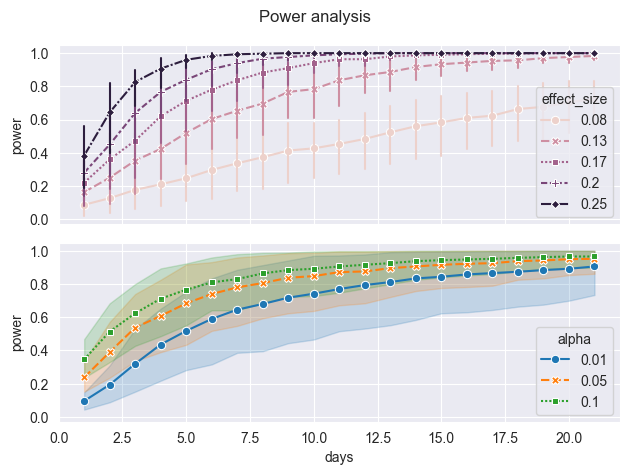

In [22]:
# Plot power vs. variables
fig, ax = plt.subplots(2, sharey = True, sharex = True)
plt.suptitle("Power analysis")

_ = sns.lineplot(
    power_data,
    x = "days",
    y = "power",
    hue = "effect_size",
    style = "effect_size",
    markers = True,
    err_style = "bars",
    ax = ax[0]
)

_ = sns.lineplot(
    power_data,
    x = "days",
    y = "power",
    hue = power_data["alpha"].astype(str),
    style = power_data["alpha"].astype(str),
    markers = True,
    ax = ax[1]
)

To detect the minimum standardized effect size with a power of ~0.8-0.9 at significance 0.05, we need 6-7 days.

Can calculate the required sample size for a given power, significance & standardized effect size using `TTestIndPower.solve_power`.

## T-tests

In [23]:
# Define testing function
def t_test(days, alpha = 0.05):

    # Generate control data
    control_daily_visitors = get_daily_visitors(days)
    control_daily_conversions = get_daily_conversions(control_daily_visitors, conversion_control)
    control_array = get_conversions_array(control_daily_visitors, control_daily_conversions)
    n_obs_control = len(control_array)

    # Generate experiment data
    experiment_daily_visitors = get_daily_visitors(days)
    experiment_daily_conversions = get_daily_conversions(experiment_daily_visitors, conversion_experiment)
    experiment_array = get_conversions_array(experiment_daily_visitors, experiment_daily_conversions)
    n_obs_experiment = len(experiment_array)

    # Perform test
    # "alternative" relates first sample to the second
    t, p, df = ttest_ind(
        experiment_array,
        control_array,
        alternative = "larger",
        usevar = "unequal"
        )
    
    # Calculate power
    power = power_calc.power(
        effect_size = min_std_effect,
        nobs1 = n_obs_control,
        alpha = alpha,
        ratio = n_obs_experiment / n_obs_control
    )
    
    # Print results
    print(f"N. of days: {days}")
    print(f"N. of control samples: {n_obs_control}")
    print(f"N. of experiment samples: {n_obs_experiment}")
    print(f"T-stat: {t}")
    print(f"P-value: {p}")
    print(f"Deg. of freedom: {df}")
    print(f"Power: {power}, at significance {alpha}, for std. effect size {min_std_effect}")

In [24]:
# Underpowered test
t_test(days = 2)

N. of days: 2
N. of control samples: 203
N. of experiment samples: 208
T-stat: 2.324991574893261
P-value: 0.01028731821605022
Deg. of freedom: 397.9586191147546
Power: 0.3919346703504858, at significance 0.05, for std. effect size 0.16666666666666674


In [25]:
# Adequately powered test
t_test(days = 6)

N. of days: 6
N. of control samples: 575
N. of experiment samples: 605
T-stat: 1.9169298140897988
P-value: 0.027744528530644567
Deg. of freedom: 1175.4880522667042
Power: 0.8157731671215037, at significance 0.05, for std. effect size 0.16666666666666674


In [26]:
# Overpowered test
t_test(days = 10)

N. of days: 10
N. of control samples: 1016
N. of experiment samples: 936
T-stat: 3.6260567170407976
P-value: 0.0001477896093784625
Deg. of freedom: 1848.4162829033814
Power: 0.9570028560481996, at significance 0.05, for std. effect size 0.16666666666666674


In [27]:
# Define function to run test many times & calculate type II error rate, avg. power, avg. p-value
def run_tests(days, trials = 1000, alpha = 0.05):

    false_negatives = 0
    p_values = []
    powers = []
    for i in range(trials):

        # Generate control data
        control_daily_visitors = get_daily_visitors(days)
        control_daily_conversions = get_daily_conversions(control_daily_visitors, conversion_control)
        control_array = get_conversions_array(control_daily_visitors, control_daily_conversions)
        n_obs_control = len(control_array)

        # Generate experiment data
        experiment_daily_visitors = get_daily_visitors(days)
        experiment_daily_conversions = get_daily_conversions(experiment_daily_visitors, conversion_experiment)
        experiment_array = get_conversions_array(experiment_daily_visitors, experiment_daily_conversions)
        n_obs_experiment = len(experiment_array)

        # Perform test
        # "alternative" relates first sample to the second
        t, p, df = ttest_ind(
            experiment_array,
            control_array,
            alternative = "larger",
            usevar = "unequal"
            )
        p_values.append(p)
        
        # Calculate power
        power = power_calc.power(
            effect_size = min_std_effect,
            nobs1 = n_obs_control,
            alpha = alpha,
            ratio = n_obs_experiment / n_obs_control
    )
        powers.append(power)

        if p > alpha:
            false_negatives +=1
    
    avg_power = np.mean(powers)
    avg_p = np.mean(p_values)
    fpr = false_negatives / trials
    
    print(f"N. trials: {trials}")
    print(f"Significance level: {alpha}")
    print(f"Avg. p-value: {avg_p}")
    print(f"Avg. power: {avg_power}")
    print(f"False negative rate (Type II): {fpr}")
    print(f"Difference of (1-avg. power) and FPR: {(1-avg_power) - fpr}")

In [28]:
# Underpowered tests
run_tests(days = 2)

N. trials: 1000
Significance level: 0.05
Avg. p-value: 0.1318345277945591
Avg. power: 0.3822886654005041
False negative rate (Type II): 0.692
Difference of (1-avg. power) and FPR: -0.07428866540050405


In [29]:
# Adequately powered tests
run_tests(days = 6)

N. trials: 1000
Significance level: 0.05
Avg. p-value: 0.025021227008816618
Avg. power: 0.8213909315581543
False negative rate (Type II): 0.151
Difference of (1-avg. power) and FPR: 0.027609068441845658


In [30]:
# Overpowered tests
run_tests(days = 10)

N. trials: 1000
Significance level: 0.05
Avg. p-value: 0.006093982276525344
Avg. power: 0.9609630180422881
False negative rate (Type II): 0.024
Difference of (1-avg. power) and FPR: 0.01503698195771188


Notes:

In reality, we do not know the following:

- Exact n. of samples in each group, or their ratio. We only control the number of experiment days and we have to estimate the sample sizes accordingly.
- The standard deviation of the sample outcomes. We have to estimate this from past data or knowledge.